In [61]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import Image
import tensorflow as tf
import keras
import os

In [62]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.metrics import categorical_crossentropy
from keras.models import Model, Sequential , load_model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, MaxPooling2D , Conv2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

Code for splitting the dataset into train and test

In [63]:
# import shutil

# # Define the path to your original dataset and the paths where you want to store your train and test datasets
# original_dataset_dir = 'E:/College/Third Year/1st Semester/Adv MM/Adv MM Project/ck-20231226T142304Z-001/ck'
# train_dir = 'E:/College/Third Year/1st Semester/Adv MM/Adv MM Project/ck-20231226T142304Z-001/ck/train'
# test_dir = 'E:/College/Third Year/1st Semester/Adv MM/Adv MM Project/ck-20231226T142304Z-001/ck/test'

# # Create directories for training and testing datasets if they do not exist
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)

# # Define the split ratio
# train_ratio = 0.9

# # Loop through each emotion category in the original dataset
# for emotion in os.listdir(original_dataset_dir):
#     emotion_dir = os.path.join(original_dataset_dir, emotion)
#     if os.path.isdir(emotion_dir):
#         # Get a list of all the image filenames in the emotion category
#         images = [f for f in os.listdir(emotion_dir) if os.path.isfile(os.path.join(emotion_dir, f))]

#         # Randomly shuffle the list of image filenames
#         np.random.shuffle(images)

#      #   # Split the list of image filenames into training and testing sets
#         train_size = int(len(images) * train_ratio)
#         train_images = images[:train_size]
#         test_images = images[train_size:]

#         # Create directories for the emotion category in the train and test datasets
#         train_emotion_dir = os.path.join(train_dir, emotion)

#         test_emotion_dir = os.path.join(test_dir, emotion)
#         os.makedirs(train_emotion_dir, exist_ok=True)
#         os.makedirs(test_emotion_dir, exist_ok=True)

#         # Copy the images into the corresponding directories
#         for image in train_images:
#             shutil.copy(os.path.join(emotion_dir, image), os.path.join(train_emotion_dir, image))
#         for image in test_images:
#             shutil.copy(os.path.join(emotion_dir, image), os.path.join(test_emotion_dir, image))

# print("Dataset splitting complete")

In [64]:
target_size=(48,48) #size el sowar aslun

In [65]:
train_datagen= ImageDataGenerator( #bi3ml data augmentation
    rescale=1./255, #btkhali el pixels maben 0 w 1 (Normalize) [0,1]
    rotation_range=20, # random rotate fel range [-20,+20]
    width_shift_range=0.2, #horizontal shift
    height_shift_range=0.2, #vertical shift
    shear_range=0.2, #control amount of distortion, max shear angle b 0.2
    zoom_range=0.2, #maximum zoom le had 0.2
    horizontal_flip=True, #Randomly flip images horizontally
   validation_split=0.2) #3ashan y2sm el train w el validation(el validation hatakhod 0.2 mn el train)

In [66]:
train_generator =train_datagen.flow_from_directory(
    'E:/College/Third Year/1st Semester/Adv MM/Adv MM Project/ck-20231227T033718Z-001/ck/train',
    target_size=target_size,
    color_mode='rgb', #mzbttsh bel grayscale
    batch_size=128,  #number of images that will be processed together in each iteration (number of samples in each batch)
    class_mode='categorical', #3shan aktar mn 2 classes
    subset='training') #bn7ot en el goz2 dah tb3 el training

Found 707 images belonging to 7 classes.


In [67]:
validation_generator = train_datagen.flow_from_directory(
    'E:/College/Third Year/1st Semester/Adv MM/Adv MM Project/ck-20231227T033718Z-001/ck/train',
    target_size=target_size,
    color_mode='rgb',
    batch_size=128,
    class_mode='categorical',
    subset='validation')

Found 173 images belonging to 7 classes.


In [68]:
datagen=ImageDataGenerator()
test_generator = datagen.flow_from_directory(
    'E:/College/Third Year/1st Semester/Adv MM/Adv MM Project/ck-20231227T033718Z-001/ck/test',
    target_size=target_size,
    color_mode='rgb',
    batch_size=128,
    class_mode='categorical')

Found 101 images belonging to 7 classes.


In [69]:
train_generator.class_indices

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happy': 4,
 'sadness': 5,
 'surprise': 6}

In [70]:
train_generator.image_shape

(48, 48, 3)

In [71]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 3)), #32 filter, size el filter 3x3, RelU : max(o,x), input shape (size,number of color channels:3ashan homa rgb hayb2a 3)
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), #bt2alel el spatial dim. bta3t el feature map (downsampling): btkhtar a3la value fe kol 2x2 region, el MaxPooling bi2alel el noise

    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(), #btakhod el data tkhaliha 1D array (tkhaliha vector ya3ny 3shan tedkhol lel Dense layer (Fully connected))
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(7, activation='softmax')]) #hatena el number of classes, SoftMax: converts raw scores le prob.(btedy scores mn 0 le 1 w fel akhr el summation beytla3 b 1)

In [72]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
#loss function: bt7sb el difference maben el predicted prob. w el true prob.
#el optimizer used for backpropagation and weight updates during learning
#el metrics: bn7aded ehna 3ayzin n-monitor eh (el accuracy)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
#model checkpoint is a callback class momkn yt3amalha call f ay wa2t zai akhr el epoch
#best_model.h5: bn-save el weights fih, h5 extension dih ya3ny hierarchial extension bnstkhdmo 3shan n save large amounts of numerical data zai el machine learning models
#hay-monitor el val_accuracy law zadet fa hay-save el rakam el gedid
#save best hat-make sure eno ye save el best weights w true dih 3shan yo3od y-over write law fih weight ahsan mn el mwgod
#mode='max' 3shan negib el maximum weights

In [73]:
# Callback to store the maximum training accuracy
class MaxAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None): #on_epoch_end dih function called kol ma epoch tekhlas
        current_train_accuracy = logs.get('accuracy') #bnakhod el training accuracy mn el log, el logs contains various metrics collected during training

        if epoch == 0:
            self.max_train_accuracy = current_train_accuracy
        else:
            if current_train_accuracy > self.max_train_accuracy:
                self.max_train_accuracy = current_train_accuracy

In [74]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 10, 10, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 4, 4, 128)        

In [75]:
max_accuracy_callback = MaxAccuracyCallback()
history = model.fit(train_generator, validation_data=validation_generator, epochs=500,batch_size=64,callbacks=[EarlyStopping(monitor='val_loss', patience=30 ,verbose=1),model_checkpoint, max_accuracy_callback])
#callbacks dih el haga el bit3amalaha call during training w bnstkhdm fiha el early stopping
#el batch size el hena dah bi7aded number of samples f kol iteration(epoch) processed fel back w forward pass
#bn monitor el validation loss law mat7asensh f 10 epochs (patience) hai3ml early stop w el verbose = 1 bt print en hasal early stopping

Epoch 1/500
6/6 [==============================] - 3s 283ms/step - loss: 1.8666 - accuracy: 0.1966 - val_loss: 1.8395 - val_accuracy: 0.2428
Epoch 2/500
6/6 [==============================] - 1s 230ms/step - loss: 1.8264 - accuracy: 0.2320 - val_loss: 1.8092 - val_accuracy: 0.2543
Epoch 3/500
6/6 [==============================] - 1s 225ms/step - loss: 1.7968 - accuracy: 0.2574 - val_loss: 1.8008 - val_accuracy: 0.2543
Epoch 4/500
6/6 [==============================] - 1s 238ms/step - loss: 1.7699 - accuracy: 0.2673 - val_loss: 1.7715 - val_accuracy: 0.2775
Epoch 5/500
6/6 [==============================] - 1s 255ms/step - loss: 1.7407 - accuracy: 0.2999 - val_loss: 1.7330 - val_accuracy: 0.3006
Epoch 6/500
6/6 [==============================] - 1s 228ms/step - loss: 1.6866 - accuracy: 0.3380 - val_loss: 1.6843 - val_accuracy: 0.3757
Epoch 7/500
6/6 [==============================] - 1s 216ms/step - loss: 1.6182 - accuracy: 0.3762 - val_loss: 1.6341 - val_accuracy: 0.3815
Epoch 8/500
6

In [76]:
# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

In [77]:
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")
# Print the maximum training accuracy
print(f"Maximum Training Accuracy: {max_accuracy_callback.max_train_accuracy}")

# Print the maximum validation accuracy
print(f"Maximum Validation Accuracy: {model_checkpoint.best}")  # model_checkpoint.best contains the highest validation accuracy

1/1 [==============================] - 0s 226ms/step - loss: 42.6388 - accuracy: 0.9505
Test Accuracy: 0.9504950642585754
Maximum Training Accuracy: 0.9632248878479004
Maximum Validation Accuracy: 0.8901734352111816


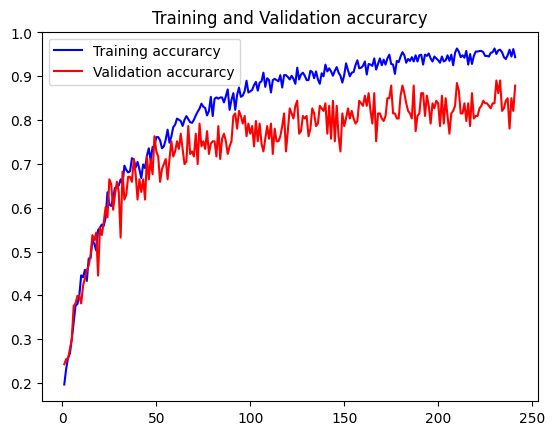

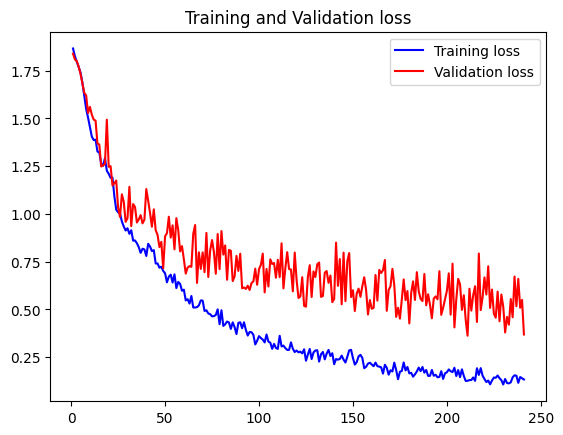

In [78]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
#Train and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training accurarcy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure() # to plot new figure
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 25ms/step


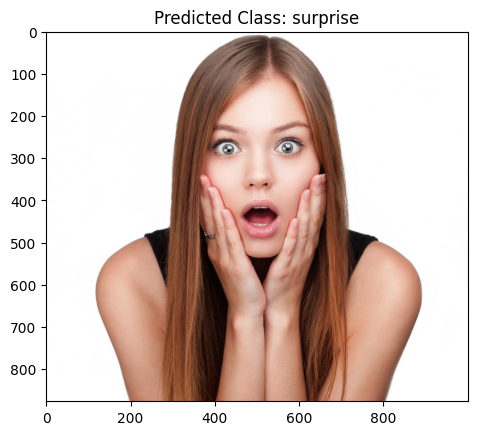

In [86]:
def prepare(img_path):
  img = image.load_img(img_path, target_size=(48, 48))
  x = image.img_to_array(img)
  x = x/255
  return np.expand_dims(x, axis=0)
img_path = 'surprise.jpg'
result = model.predict([prepare(img_path)])
predicted_class_index = np.argmax(result)
class_names = sorted(train_generator.class_indices, key=lambda k: train_generator.class_indices[k])
predicted_class_name = class_names[predicted_class_index]
predicted_class_name = class_names[predicted_class_index]
Emotion = image.load_img(img_path)
plt.imshow(Emotion)
plt.title(f'Predicted Class: {predicted_class_name}')
plt.show()

1/1 [==============================] - 0s 25ms/step


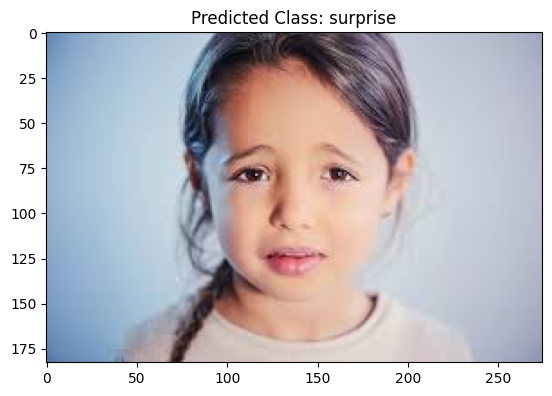

In [88]:
def prepare(img_path):
  img = image.load_img(img_path, target_size=(48, 48))
  x = image.img_to_array(img)
  x = x/255
  return np.expand_dims(x, axis=0)
img_path = 'WhatsApp Image 2023-12-26 at 19.52.45_5042bedc.jpg'
result = model.predict([prepare(img_path)])
predicted_class_index = np.argmax(result)
class_names = sorted(train_generator.class_indices, key=lambda k: train_generator.class_indices[k])
predicted_class_name = class_names[predicted_class_index]
predicted_class_name = class_names[predicted_class_index]
Emotion = image.load_img(img_path)
plt.imshow(Emotion)
plt.title(f'Predicted Class: {predicted_class_name}')
plt.show()